#IDS Menggunakan Machine Learning/Deep Learning 
Notebook ini melibatkan pembuatan model pembelajaran mesin & pembelajaran mendalam untuk mengklasifikasikan data yang diperoleh sebagai intrusi jaringan ke dalam kelas yang berbeda (Normal atau Serangan). Diberikan titik sampel, tujuan model pembelajaran mesin adalah untuk mengklasifikasikan apakah intrusi yang dilakukan adalah berupa paket aliran Normal atau terdapat serangan DDoS (TCP, UDP, ICMP).

# Mengimpor Library
Pertama, mengimpor Library yang dibutuhkan untuk memulai alur kerja. Library yang gunakan adalah:
* NumPy
* Panda
* Matplotlib
* Scikit-learn
* Keras
* TensorFlow

In [ ]:
# import librari
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
import tensorflow as tf 
from sklearn.metrics import classification_report

# Memuat Data
Langkah pertama adalah memuat data yang tersedia ke dalam memori kita.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
# memuat data ke dalam memori
dataset = pd.read_csv('drive/MyDrive/VPS Dataset/DDoS VPS Dataset Wireshark.pcap_Flow.csv')
dataset

CPU times: user 353 ms, sys: 93.6 ms, total: 446 ms
Wall time: 1.44 s


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.43.66-103.160.63.239-51604-22-6,103.160.63.239,22,192.168.43.66,51604,6,04/09/2022 03:19:21 AM,241,1,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,192.168.43.66-103.160.63.239-51604-22-6,103.160.63.239,22,192.168.43.66,51604,6,04/09/2022 03:19:24 AM,3412,2,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,192.168.43.66-103.160.63.239-51604-22-6,103.160.63.239,22,192.168.43.66,51604,6,04/09/2022 03:19:27 AM,348,1,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,192.168.43.66-103.160.63.239-51604-22-6,103.160.63.239,22,192.168.43.66,51604,6,04/09/2022 03:19:30 AM,149,1,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,192.168.43.66-103.160.63.239-51604-22-6,103.160.63.239,22,192.168.43.66,51604,6,04/09/2022 03:19:33 AM,11610,2,2,...,0,0.0,0.0,0.0,0.0,11478.0,0.0,11478.0,11478.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38720,192.168.43.66-103.160.63.239-0-0-0,192.168.43.66,0,103.160.63.239,0,0,04/09/2022 03:54:56 AM,62108,0,2,...,0,0.0,0.0,0.0,0.0,62108.0,0.0,62108.0,62108.0,DDOS attack-ICMP
38721,192.168.43.66-103.160.63.239-0-0-0,192.168.43.66,0,103.160.63.239,0,0,04/09/2022 03:54:57 AM,61661,0,2,...,0,0.0,0.0,0.0,0.0,61661.0,0.0,61661.0,61661.0,DDOS attack-ICMP
38722,192.168.43.66-103.160.63.239-0-0-0,192.168.43.66,0,103.160.63.239,0,0,04/09/2022 03:54:58 AM,68093,0,2,...,0,0.0,0.0,0.0,0.0,68093.0,0.0,68093.0,68093.0,DDOS attack-ICMP
38723,192.168.43.66-103.160.63.239-0-0-0,192.168.43.66,0,103.160.63.239,0,0,04/09/2022 03:54:59 AM,69617,0,2,...,0,0.0,0.0,0.0,0.0,69617.0,0.0,69617.0,69617.0,DDOS attack-ICMP


#Drop jumlah kolom
Hapus kolom pada dataset yang berjumlah 84 menjadi 80 kolom karena kolom tersebut merupakan type data berupa objek yaitu Flow ID, Src IP,  Src Port, Dst IP.

In [ ]:
#memeriksa Type Data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38725 entries, 0 to 38724
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            38725 non-null  object 
 1   Src IP             38725 non-null  object 
 2   Src Port           38725 non-null  int64  
 3   Dst IP             38725 non-null  object 
 4   Dst Port           38725 non-null  int64  
 5   Protocol           38725 non-null  int64  
 6   Timestamp          38725 non-null  object 
 7   Flow Duration      38725 non-null  int64  
 8   Tot Fwd Pkts       38725 non-null  int64  
 9   Tot Bwd Pkts       38725 non-null  int64  
 10  TotLen Fwd Pkts    38725 non-null  float64
 11  TotLen Bwd Pkts    38725 non-null  float64
 12  Fwd Pkt Len Max    38725 non-null  float64
 13  Fwd Pkt Len Min    38725 non-null  float64
 14  Fwd Pkt Len Mean   38725 non-null  float64
 15  Fwd Pkt Len Std    38725 non-null  float64
 16  Bwd Pkt Len Max    387

In [ ]:
dataset.drop(['Flow ID','Src IP','Dst IP','Timestamp'],axis=1,inplace=True)

In [ ]:
dataset

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,51604,6,241,1,2,1176.0,1400.0,1176.0,1176.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,22,51604,6,3412,2,3,1416.0,1560.0,1400.0,16.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,22,51604,6,348,1,2,936.0,1400.0,936.0,936.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,22,51604,6,149,1,2,328.0,1400.0,328.0,328.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,22,51604,6,11610,2,2,1432.0,1400.0,1400.0,32.0,...,0,0.0,0.0,0.0,0.0,11478.0,0.0,11478.0,11478.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38720,0,0,0,62108,0,2,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,62108.0,0.0,62108.0,62108.0,DDOS attack-ICMP
38721,0,0,0,61661,0,2,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,61661.0,0.0,61661.0,61661.0,DDOS attack-ICMP
38722,0,0,0,68093,0,2,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,68093.0,0.0,68093.0,68093.0,DDOS attack-ICMP
38723,0,0,0,69617,0,2,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,69617.0,0.0,69617.0,69617.0,DDOS attack-ICMP


#EDA (Analisis Data Eksplorasi) 
Untuk membuat pemahaman yang tepat dari dataset yang kita gunakan, kita akan melakukan bief EDA (Exploratory Data Analysis). EDA dibagi menjadi: 
* Data Visuals
* Data Understanding
* Data Analysis

In [ ]:
# cek jumlah baris dan kolom
print('Number of Rows (Samples): %s' % str((dataset.shape[0])))
print('Number of Columns (Features): %s' % str((dataset.shape[1])))

Number of Rows (Samples): 38725
Number of Columns (Features): 80


#Memeriksa Kolom
Memeriksa nama kolom pada dataset

In [ ]:
# memeriksa kolom dalam data
dataset.columns

Index(['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       

#Type Data
Memeriksa tipe data pada dataset

In [ ]:
#memeriksa Type Data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38725 entries, 0 to 38724
Data columns (total 80 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Src Port           38725 non-null  int64  
 1   Dst Port           38725 non-null  int64  
 2   Protocol           38725 non-null  int64  
 3   Flow Duration      38725 non-null  int64  
 4   Tot Fwd Pkts       38725 non-null  int64  
 5   Tot Bwd Pkts       38725 non-null  int64  
 6   TotLen Fwd Pkts    38725 non-null  float64
 7   TotLen Bwd Pkts    38725 non-null  float64
 8   Fwd Pkt Len Max    38725 non-null  float64
 9   Fwd Pkt Len Min    38725 non-null  float64
 10  Fwd Pkt Len Mean   38725 non-null  float64
 11  Fwd Pkt Len Std    38725 non-null  float64
 12  Bwd Pkt Len Max    38725 non-null  float64
 13  Bwd Pkt Len Min    38725 non-null  float64
 14  Bwd Pkt Len Mean   38725 non-null  float64
 15  Bwd Pkt Len Std    38725 non-null  float64
 16  Flow Byts/s        387

#Menghitung jumlah data
Penghitungan data menggunakan seaborn dengan Label sebagai data plot 

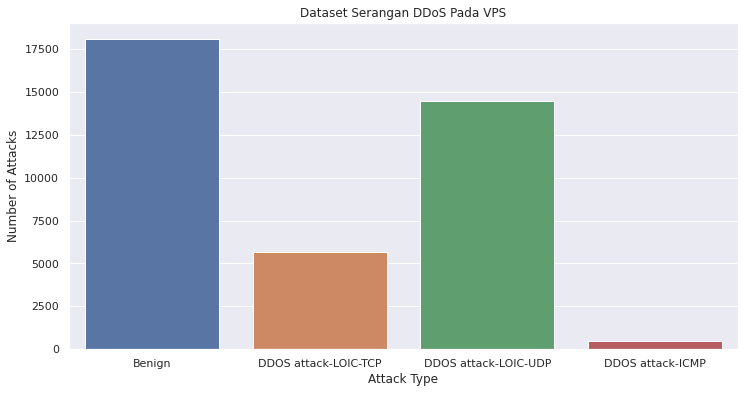

Benign                  18101
DDOS attack-LOIC-UDP    14463
DDOS attack-LOIC-TCP     5660
DDOS attack-ICMP          501
Name: Label, dtype: int64

In [ ]:
# membuat nomor plot label
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=dataset)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.title("Dataset Serangan DDoS Pada VPS")
plt.show()
dataset['Label'].value_counts()

# Data Preprocessing
Pra-pemrosesan data tidak sepenuhnya berisi data yang bersih, data null atau hilang dapat terjadi pada saat pengambilan dataset. oleh karena itu perlu dilakukan pembersihan data agar model dapat bekerja mendapatkan hasil maksimal.

In [ ]:
# memeriksa data NaN dan Infinity bernilai null pada dataset
dataset = dataset.replace([np.inf,-np.inf, 'Infinity'],np.nan)
dataset.isna().sum().to_numpy()

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 21,
       21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
print('Data NaN dan Infinity sebelum dibuang',dataset.isnull().sum().sum())

Data NaN dan Infinity sebelum dibuang 42


In [ ]:
# menghapus data null pada kolom
dataset = dataset.dropna()
dataset.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print('Data NaN dan Infinity setelah dibuang',dataset.isnull().sum().sum())

Data NaN dan Infinity setelah dibuang 0


## Label Encoding
Fitur Label dalam data berisi 4 label sebagai **Benign (Normal)**, **DDOS attack-LOIC-UDP**, **DDOS attack-LOIC-TCP** dan **DDOS attack-ICMP**. Semua label tersebut berupa format string (objek). Pengubahan dilakukan dengan encoder menjadi bentuk data array. 

In [ ]:
# Membuat label berupa angka
label_encoder = LabelEncoder()
dataset['Label']= label_encoder.fit_transform(dataset['Label'])
dataset['Label'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([0, 2, 3, 1])

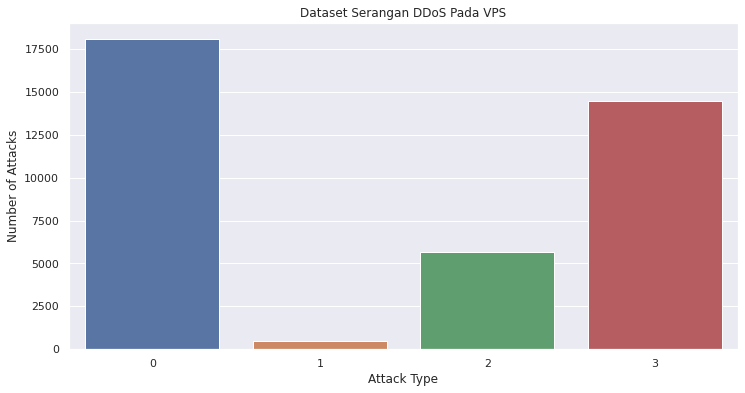

0    18097
3    14461
2     5647
1      499
Name: Label, dtype: int64

In [ ]:
# membuat nomor plot label
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=dataset)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.title("Dataset Serangan DDoS Pada VPS")
plt.show()
dataset['Label'].value_counts()

## Pembagian Data Latih dan Data Uji
Tahap ini melibatkan data yang dibagi menjadi Latih & Uji. Data pelatihan akan digunakan untuk melatih model, dan data pengujian akan digunakan untuk memeriksa kinerja model pada dataset yang tidak terlihat. Dengan menggunakan pemisahan **80-20**, yaitu, **80%** data yang akan digunakan untuk pelatihan & **20%** untuk digunakan untuk tujuan pengujian.

In [ ]:
dataset.shape

(38704, 80)

In [ ]:
## Membagi data latih dan uji
proporsi = 0.7
data_latih = dataset.sample(frac=proporsi)
data_uji = dataset.drop(data_latih.index)
print(f'Shape Data Latih {data_latih.shape}')
print(f'Shape Data Uji {data_uji.shape}')

Shape Data Latih (27093, 80)
Shape Data Uji (11611, 80)


In [ ]:
target_latih = data_latih['Label']
target_uji = data_uji['Label']
target_latih.unique(), target_uji.unique()

(array([3, 0, 2, 1]), array([0, 2, 3, 1]))

In [ ]:
data_latih

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
27075,63354,80,17,20748,1,1,32.0,32.0,32.0,32.0,...,0,0.0,0.0,0.0,0.0,20748.0,0.0,20748.0,20748.0,3
37552,61872,22,6,7314,1,2,0.0,128.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,7262.0,0.0,7262.0,7262.0,0
17355,63354,80,17,20784,1,1,32.0,32.0,32.0,32.0,...,0,0.0,0.0,0.0,0.0,20784.0,0.0,20784.0,20784.0,3
12637,22,51604,6,16440,1,2,64.0,64.0,64.0,64.0,...,0,35.0,0.0,35.0,35.0,16405.0,0.0,16405.0,16405.0,0
4952,54638,80,6,94,1,1,128.0,0.0,128.0,128.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485,54321,80,6,86,1,1,160.0,0.0,160.0,160.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
16690,63354,80,17,20554,1,1,32.0,32.0,32.0,32.0,...,0,0.0,0.0,0.0,0.0,20554.0,0.0,20554.0,20554.0,3
35962,61872,22,6,11914,1,2,0.0,128.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,11871.0,0.0,11871.0,11871.0,0
28426,63355,80,17,21011,1,1,32.0,32.0,32.0,32.0,...,0,0.0,0.0,0.0,0.0,21011.0,0.0,21011.0,21011.0,3


In [ ]:
data_uji

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,51604,6,241,1,2,1176.0,1400.0,1176.0,1176.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,22,51604,6,232,1,2,936.0,1400.0,936.0,936.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,22,51604,6,363,1,2,936.0,1400.0,936.0,936.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
18,52464,80,6,3553,1,5,96.0,0.0,96.0,96.0,...,0,225.0,0.0,225.0,225.0,3328.0,0.0,3328.0,3328.0,2
21,52465,80,6,352,2,5,160.0,0.0,128.0,32.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38706,0,0,0,63638,0,2,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,63638.0,0.0,63638.0,63638.0,1
38708,0,0,0,53381,0,2,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,53381.0,0.0,53381.0,53381.0,1
38720,0,0,0,62108,0,2,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,62108.0,0.0,62108.0,62108.0,1
38721,0,0,0,61661,0,2,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,61661.0,0.0,61661.0,61661.0,1


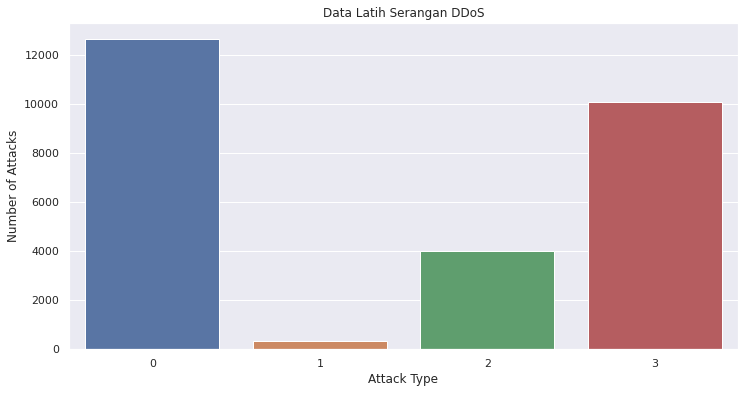

0    12657
3    10083
2     4014
1      339
Name: Label, dtype: int64

In [ ]:
# make a plot number of labels
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=data_latih)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.title("Data Latih Serangan DDoS")
plt.show()
data_latih['Label'].value_counts()

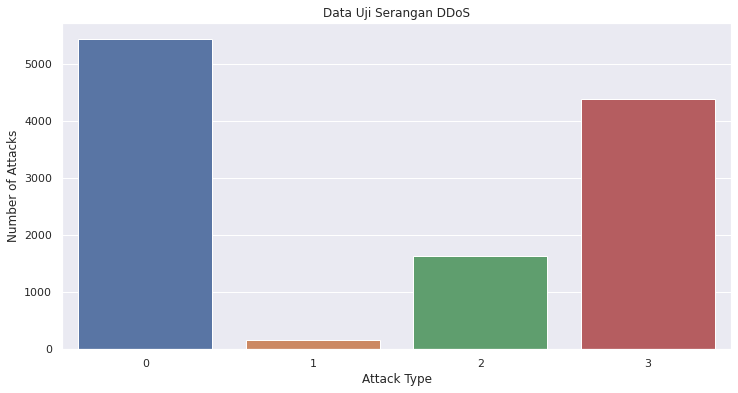

0    5440
3    4378
2    1633
1     160
Name: Label, dtype: int64

In [ ]:
# make a plot number of labels
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=data_uji)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.title("Data Uji Serangan DDoS")
plt.show()
data_uji['Label'].value_counts()

# Membuat variabel X dan Y (CNN)

In [ ]:
y_latih = to_categorical(target_latih, num_classes=4)
y_uji = to_categorical(target_uji, num_classes=4)

In [ ]:
y_latih

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
y_uji

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
# mambuat pembagian latih & uji
X_latih = data_latih.iloc[:, :-1].values
X_uji = data_uji.iloc[:, :-1].values
X_uji

array([[2.2000e+01, 5.1604e+04, 6.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.2000e+01, 5.1604e+04, 6.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.2000e+01, 5.1604e+04, 6.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 6.2108e+04,
        6.2108e+04],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 6.1661e+04,
        6.1661e+04],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 6.8093e+04,
        6.8093e+04]])

In [ ]:
print(X_latih.shape)
print(X_uji.shape)
print(y_latih.shape)
print(y_uji.shape)

(27093, 79)
(11611, 79)
(27093, 4)
(11611, 4)


In [ ]:
# reshape the data for CNN
X_latih = X_latih.reshape(len(X_latih), X_latih.shape[1], 1)
X_uji = X_uji.reshape(len(X_uji), X_uji.shape[1], 1)
X_latih.shape, X_uji.shape

((27093, 79, 1), (11611, 79, 1))

## Membuat rangkaian arsitektur pada Model CNN

In [ ]:
# membuat function pada model CNN
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(79, 1)))
    model.add(BatchNormalization())
    
    # menambah pooling layer
    model.add(MaxPooling1D(pool_size=(4), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(79, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(4), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(79, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(4), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 79, 64)            448       
                                                                 
 batch_normalization (BatchN  (None, 79, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 40, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 64)            24640     
                                                                 
 batch_normalization_1 (Batc  (None, 40, 64)           256       
 hNormalization)                                                 
                                                        

In [ ]:
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_latih, y_latih, epochs=50, batch_size=32, 
          validation_data=(X_uji, y_uji), callbacks=[logger])

Epoch 1/50
847/847 [==============================] - 28s 31ms/step - loss: 0.0606 - accuracy: 0.9839 - val_loss: 0.0287 - val_accuracy: 0.9953
Epoch 2/50
847/847 [==============================] - 23s 28ms/step - loss: 0.0153 - accuracy: 0.9966 - val_loss: 0.0119 - val_accuracy: 0.9980
Epoch 3/50
847/847 [==============================] - 25s 30ms/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0220 - val_accuracy: 0.9936
Epoch 4/50
847/847 [==============================] - 23s 27ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.0085 - val_accuracy: 0.9983
Epoch 5/50
847/847 [==============================] - 24s 28ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.1563 - val_accuracy: 0.9730
Epoch 6/50
847/847 [==============================] - 25s 29ms/step - loss: 0.0098 - accuracy: 0.9976 - val_loss: 0.0179 - val_accuracy: 0.9943
Epoch 7/50
847/847 [==============================] - 24s 28ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0174 - val_accuracy:

In [ ]:
# periksa kinerja model CNN
scores = model.evaluate(X_uji, y_uji)
print("%s: %.3f%%" % (model.metrics_names[1], scores[1] * 100))

model.save("model.h5")
print("Saved model to disk")

363/363 [==============================] - 5s 14ms/step - loss: 0.0241 - accuracy: 0.9981
accuracy: 99.811%
Saved model to disk


In [ ]:
# memeriksa history pada model
history = his.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

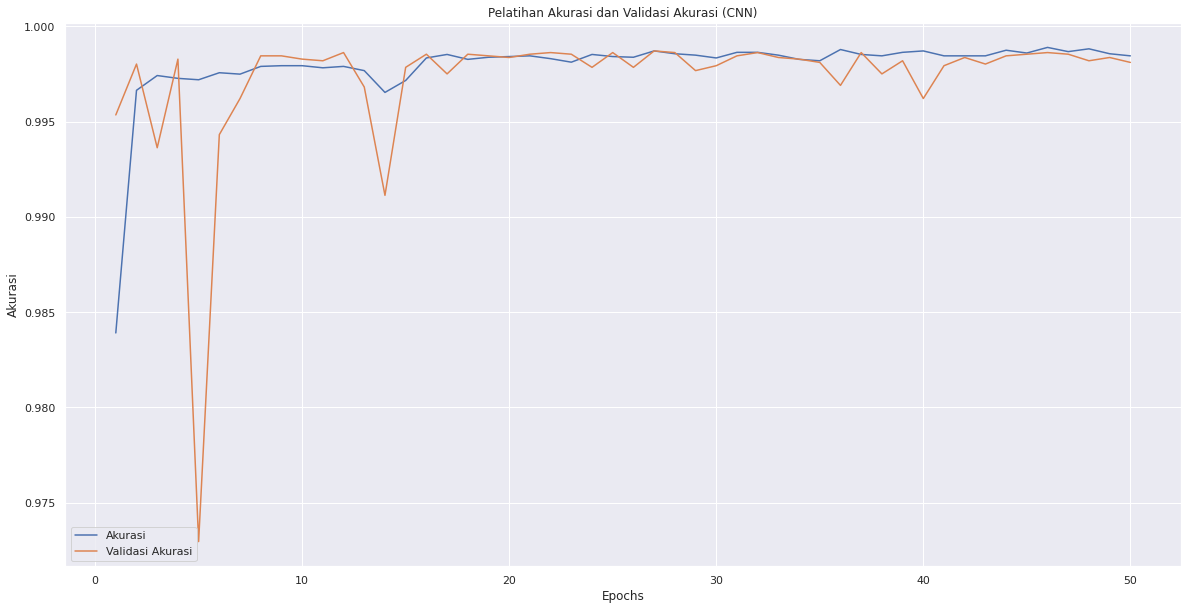

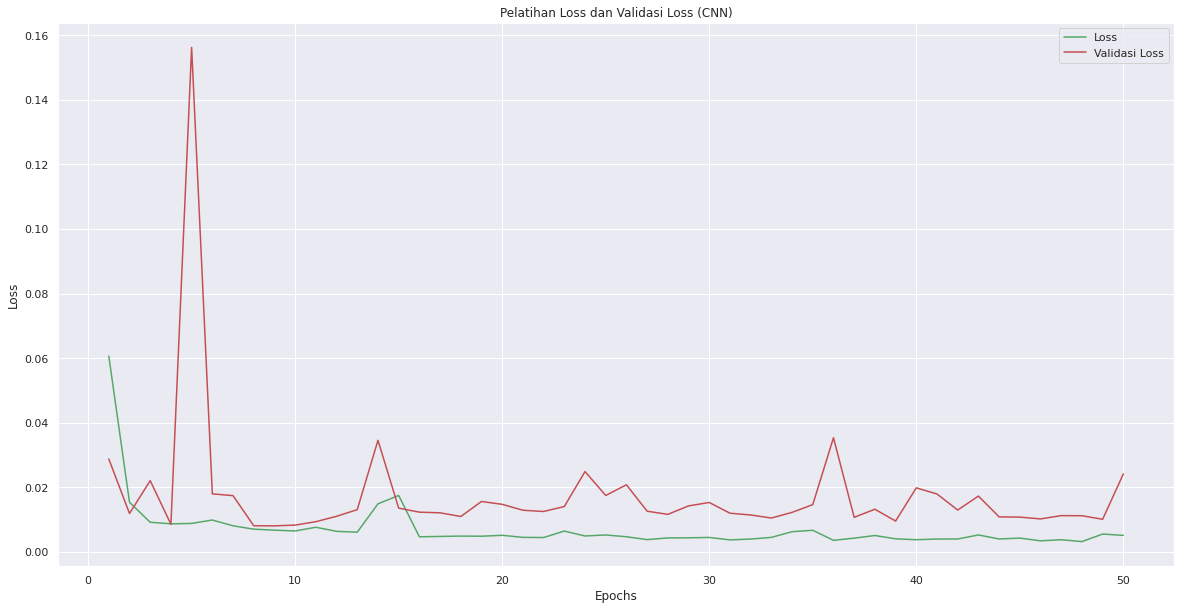

In [ ]:
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# memvisualisasikan pelatihan akurasi dan validasi akurasi
plt.figure(figsize=(20, 10))
plt.title('Pelatihan Akurasi dan Validasi Akurasi (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.plot(epochs, acc, label='Akurasi')
plt.plot(epochs, val_acc, label='Validasi Akurasi')
plt.legend()

# memvisualisasikan pelatihan loss dan validasi loss
plt.figure(figsize=(20, 10))
plt.title('Pelatihan Loss dan Validasi Loss (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='Loss', color='g')
plt.plot(epochs, val_loss, label='Validasi Loss', color='r')
plt.legend()

363/363 [==============================] - 3s 8ms/step


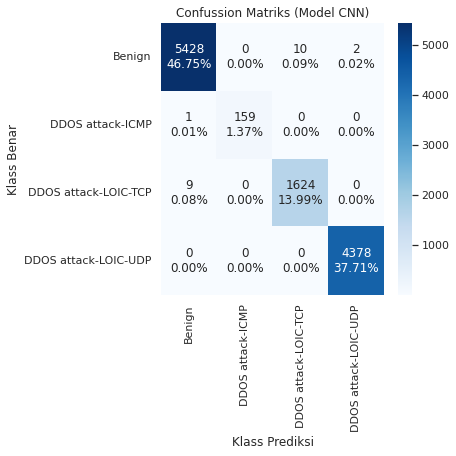

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
y_pred = model.predict(X_uji)

y_pred_cm  = np.argmax(y_pred, axis=1)
y_uji_cm  = np.argmax(y_uji, axis=1)

cm = confusion_matrix(y_uji_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)

label = ['Benign','DDOS attack-ICMP','DDOS attack-LOIC-TCP','DDOS attack-LOIC-UDP']

plt.figure(figsize=(5,5))
plt.title('Confussion Matriks (Model CNN)')
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
plt.ylabel('Klass Benar')
plt.xlabel('Klass Prediksi')
plt.show()

In [ ]:
import sklearn.metrics
target_names = ['Benign','DDOS attack-ICMP','DDOS attack-LOIC-TCP','DDOS attack-LOIC-UDP']
print(sklearn.metrics.classification_report(y_uji_cm,y_pred_cm,labels = [0,1,2,3], target_names=target_names))

print('Rata - Rata :' )
# Precision = (TP) / (TP + FP)
precision = precision_score(y_uji_cm, y_pred_cm, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_uji_cm, y_pred_cm, average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_uji_cm, y_pred_cm, average='weighted')
print('F1 score: %f' % f1)
# acc: (tp+tn) / (tp + fp + fn + tn)
acc = accuracy_score(y_uji_cm, y_pred_cm)
print('Accuracy: %f' % acc)

                      precision    recall  f1-score   support

              Benign       1.00      1.00      1.00      5440
    DDOS attack-ICMP       1.00      0.99      1.00       160
DDOS attack-LOIC-TCP       0.99      0.99      0.99      1633
DDOS attack-LOIC-UDP       1.00      1.00      1.00      4378

            accuracy                           1.00     11611
           macro avg       1.00      1.00      1.00     11611
        weighted avg       1.00      1.00      1.00     11611

Rata - Rata :
Precision: 0.998106
Recall: 0.998105
F1 score: 0.998105
Accuracy: 0.998105


In [ ]:
from sklearn.metrics import classification_report



print(classification_report(y_uji_cm, y_pred_cm, target_names= ['Benign','DDOS attack-ICMP','DDOS attack-LOIC-TCP','DDOS attack-LOIC-UDP']()))
                            
loss, accuracy = model.evaluate(X_uji, y_uji, verbose=1)
print("Data Uji: Akurasi = %.3f%%  ;  loss = %.3f%%" % (accuracy *100, loss *100))



                      precision    recall  f1-score   support

              Benign       1.00      1.00      1.00      5440
    DDOS attack-ICMP       1.00      0.99      1.00       160
DDOS attack-LOIC-TCP       0.99      0.99      0.99      1633
DDOS attack-LOIC-UDP       1.00      1.00      1.00      4378

            accuracy                           1.00     11611
           macro avg       1.00      1.00      1.00     11611
        weighted avg       1.00      1.00      1.00     11611

363/363 [==============================] - 3s 9ms/step - loss: 0.0241 - accuracy: 0.9981
Data Uji: Akurasi = 99.811%  ;  loss = 2.412%
